In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_lambdas_autoencoder, train_lambdas_cov
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *

# Process Data

## 1. Load preprocessed images and tabular data
Several preprocessing steps were conducted on the raw images and tabular data - see notebook "data_preprocessing". 

In [15]:
images = np.load("../data/images/cleaned_images.npy")
tracks = np.load("../data/tracks/filtered_tracks.npy")
labels = np.load("../data/labels/filtered_y_train.npy")
labels_all = np.load("../data/labels/filtered_y_train_all_fates.npy")

print("Images shape: ", images.shape, "Tracks shape: ", tracks.shape, "Labels shape: ", labels.shape)

Images shape:  (1385, 1080, 2, 20, 20) Tracks shape:  (1385, 1080, 19) Labels shape:  (1385,)


### checking if data is the same

In [3]:
filtered_images_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_images.npy")
filtered_tracks_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_tracks.npy")
filtered_labels_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filteresd_y_train.npy")

In [4]:
np.unique(np.nonzero(images[:,0,:,:] != filtered_images_previous)[0])

array([], dtype=int64)

## 2. Prepare for model training

### 1. FRET ratio calculation

In [16]:
fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] 
fret_images = np.nan_to_num(fret_images, nan=0.0)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_58879/3830351353.py:1: RuntimeWarning: invalid value encountered in divide
  fret_images = images[:,:,0,:,:] / images[:,:,1,:,:]


In [19]:
fret_images[100,0].max()

1.2451456310679612

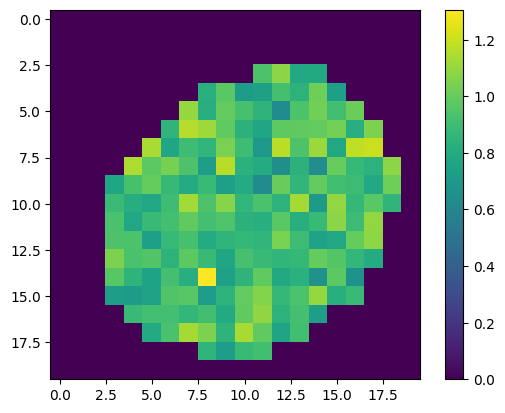

In [23]:
plt.imshow(fret_images[0,1001,:,:])
plt.colorbar()

### 2. Normalise images frame-wise

In [24]:
norm_images = normalize_images_per_frame(fret_images)

In [25]:
norm_images[0,0].max()

0.7094305052553326

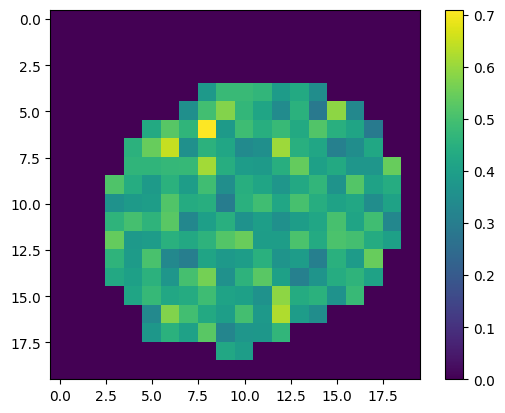

In [115]:
plt.imshow(norm_images[0,0,:,:])
plt.colorbar()

### 3. Center cells

In [26]:
centered_images = center_cells(norm_images)

### 4. Train-test split

In [27]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )
    
train_images = centered_images[train_indexes]
train_labels = labels[train_indexes]
train_tracks = tracks[train_indexes]
test_images = centered_images[test_indexes]
test_labels = labels[test_indexes]
test_tracks = tracks[test_indexes]

In [32]:
test_images[:,0].max()

0.8816826454338641

In [12]:
np.save("../data/images/train_images.npy", train_images)
np.save("../data/images/test_images.npy", test_images)
np.save("../data/labels/train_labels.npy", train_labels)
np.save("../data/labels/test_labels.npy", test_labels)
np.save("../data/tracks/train_tracks.npy", train_tracks)
np.save("../data/tracks/test_tracks.npy", test_tracks)

### 5. Data Augmentation

In [2]:
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [8]:
train_images.shape

(1108, 1080, 20, 20)

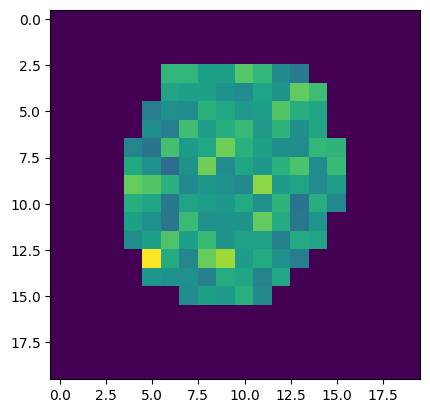

In [7]:
plt.imshow(train_images[0,0,:,:])

In [5]:
import numpy as np

def augment_dataset(cell_images, labels, augmentations, fate_0_label=0, fate_1_label=1, seed=42):
    """
    Augments a dataset of cell movies (cells, time, height, width), balances fate 0 and fate 1,
    and ensures reproducibility by setting a seed.

    Args:
        cell_images (numpy.ndarray): Array of shape (cells, time, height, width).
        labels (numpy.ndarray): 1D array of labels corresponding to cell fates.
        augmentations (function): Function that applies augmentations to an image sequence.
        fate_0_label (int): Label for fate 0 cells.
        fate_1_label (int): Label for fate 1 cells.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Augmented and balanced (final_images, final_labels).
    """
    np.random.seed(seed)  # Ensure reproducibility

    # Separate fate 0 and fate 1 in the dataset
    fate_0_images = cell_images[labels == fate_0_label]
    fate_1_images = cell_images[labels == fate_1_label]

    # Apply augmentations to each time frame of each cell sequence
    augmented_fate_0 = np.concatenate([augmentations(movie) for movie in fate_0_images], axis=0)
    augmented_fate_1 = np.concatenate([augmentations(movie) for movie in fate_1_images], axis=0)

    # Combine original and augmented data
    fate_0_combined = np.concatenate([fate_0_images, augmented_fate_0], axis=0)
    fate_1_combined = np.concatenate([fate_1_images, augmented_fate_1], axis=0)

    # Balance fate 0 to match the number of fate 1 samples
    target_count = len(fate_1_combined)
    balanced_fate_0 = fate_0_combined[np.random.choice(
        len(fate_0_combined), size=target_count, replace=len(fate_0_combined) < target_count
    )]

    # Merge balanced datasets
    final_images = np.concatenate([balanced_fate_0, fate_1_combined], axis=0)
    final_labels = np.array([fate_0_label] * len(balanced_fate_0) + [fate_1_label] * len(fate_1_combined))

    # Shuffle data
    shuffle_indexes = np.random.permutation(len(final_labels))
    final_images, final_labels = final_images[shuffle_indexes], final_labels[shuffle_indexes]

    return final_images, final_labels

# **Augmentation function for time-series images**
def augmentations(movie):
    """
    Applies augmentations independently to each frame in a movie.

    Args:
        movie (numpy.ndarray): Array of shape (time, height, width).

    Returns:
        numpy.ndarray: Augmented images (new_axis is added to match input shape).
    """
    augmented_movies = []
    for frame in movie:
        augmented_frames = [
            np.flip(frame, axis=-1),  # Flip horizontally
            np.flip(frame, axis=-2),  # Flip vertically
            np.rot90(frame, k=1, axes=(-2, -1)),  # Rotate 90 degrees
            np.rot90(frame, k=2, axes=(-2, -1)),  # Rotate 180 degrees
            np.rot90(frame, k=3, axes=(-2, -1))  # Rotate 270 degrees
        ]
        augmented_movies.append(augmented_frames)

    return np.array(augmented_movies).transpose(1, 0, 2, 3)  # Shape (augments, time, height, width)


In [6]:
train_images_augmented, train_labels_augmented = augment_dataset(train_images, train_labels, augmentations)

In [7]:
train_images_augmented.shape

(2184, 1080, 20, 20)

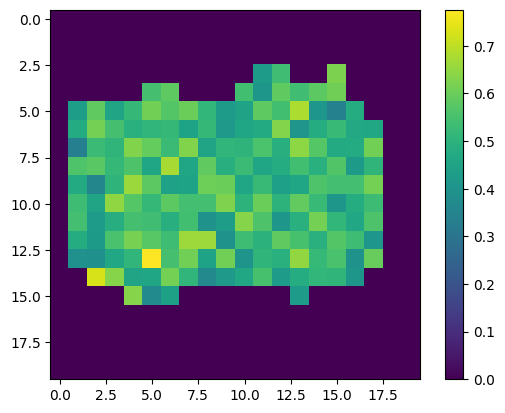

In [6]:
plt.imshow(train_images_augmented[0,0,:,:])
plt.colorbar()

In [4]:
train_images_augmented.shape, train_labels_augmented.shape

((2184, 1080, 20, 20), (2184,))

In [ ]:
# np.save("../data/images/train_images_augmented.npy", train_images_augmented)
# np.save("../data/labels/train_labels_augmented.npy", train_labels_augmented)

In [7]:
## FOR VISUALISATION PURPOSES ONLY ## - augment test set
test_images_augmented, test_labels_augmented = augment_dataset(test_images, test_labels, augmentations)

### 6. Stretch image intensities in a frame-wise way
This is done to do a scaling of the intensities in each cell, so that the minimum value is 0 (but keeping the same "relationship" between pixel values)

In [8]:
stretched_x_train, stretched_x_test = stretch_intensities_global(train_images_augmented, test_images)

In [8]:
stretched_x_train, stretched_x_test_augmented = stretch_intensities_global(train_images_augmented, test_images_augmented)

In [9]:
np.save("../data/images/stretched_x_test_augmented.npy", stretched_x_test_augmented)

In [22]:
np.save("../data/images/train_images_augmented_stretched.npy", stretched_x_train)
np.save("../data/images/test_images_augmented_stretched.npy", stretched_x_test)
np.save("../data/labels/train_labels_augmented.npy", train_labels_augmented)
np.save("../data/labels/test_labels.npy", test_labels)

print("Augmented images shape: ", stretched_x_train.shape, "Augmented labels shape: ", train_labels_augmented.shape, "Test images shape: ", stretched_x_test.shape, "Test labels shape: ", test_labels.shape, "Train tracks shape: ", train_tracks.shape, "Test tracks shape: ", test_tracks.shape)

Augmented images shape:  (2184, 1080, 20, 20) Augmented labels shape:  (2184,) Test images shape:  (277, 1080, 20, 20) Test labels shape:  (277,) Train tracks shape:  (1108, 1080, 19) Test tracks shape:  (277, 1080, 19)


In [21]:
stretched_x_train.min()

0.0

# Model Workflow - Training and Evaluation

In [8]:
train_images_augmented = np.load("../data/images/train_images_augmented_stretched.npy")
train_labels_augmented = np.load("../data/labels/train_labels_augmented.npy")
test_images = np.load("../data/images/test_images_augmented_stretched.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [41]:
stretched_x_train[100,0].max()

0.6389490739153574

In [55]:
len(np.nonzero(train_labels_augmented)[0])

1092

In [51]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    cell = 100
    def plot_frame(frame):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {train_labels_augmented[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, frame=IntSlider(min=0, max=1079, step=1, value=0)) # max=images.shape[0] - 1

display_movie(stretched_x_train)

interactive(children=(IntSlider(value=0, description='frame', max=1079), Output()), _dom_classes=('widget-inte…

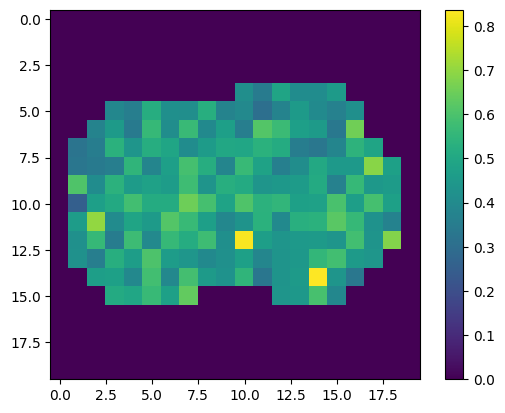

In [45]:
plt.imshow(stretched_x_train[0,3,:,:])
plt.colorbar()

In [93]:
test_images.shape

(277, 1080, 20, 20)

In [33]:
x_test_previous = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/centered_x_test.npy")

In [34]:
x_test_previous.max()

0.8596905079691756

In [100]:
np.nonzero(x_test_previous != test_images[:,0,:,:])

(array([  0,   0,   0, ..., 276, 276, 276]),
 array([ 3,  3,  3, ..., 16, 17, 17]),
 array([12, 13, 14, ..., 15, 11, 12]))

In [3]:
test_images.max() #### THE INTENSITY STRETCHING DID NOT WORK!!!!!! DO IT AGAIN

1.0

In [39]:
stretched_x_test[:,0].max()

0.9234785721484119

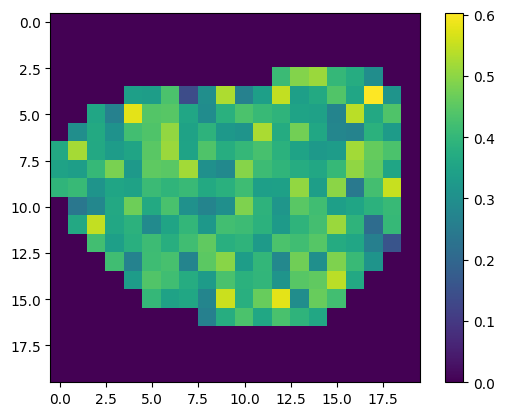

In [12]:
plt.imshow(x_test_previous[0,:,:])
plt.colorbar()

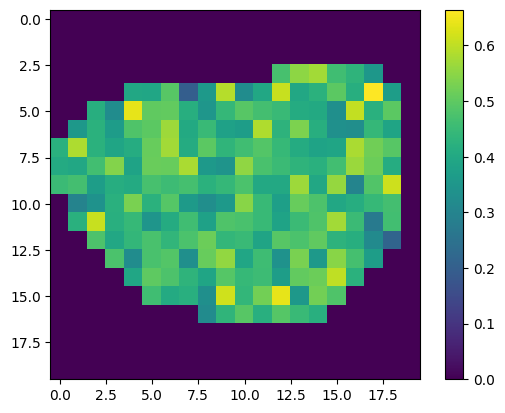

In [37]:
plt.imshow(stretched_x_test[0,0,:,:])
plt.colorbar()

In [9]:
train_images_augmented.shape

(2184, 1080, 20, 20)

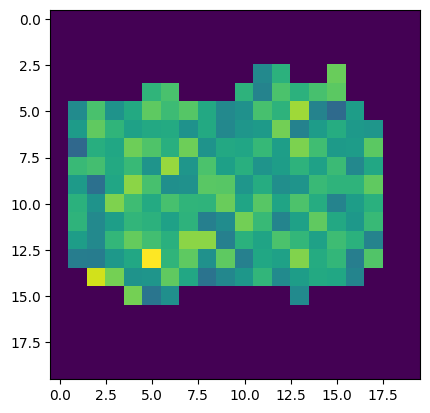

In [10]:
plt.imshow(train_images_augmented[0,0,:,:])

## Tabular Data

In [11]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

In [12]:
### removing features that would bias the model decision (i.e., the fate of the cell, mitosis time, etc.)

train_tracks_features = train_tracks[:, :, 4:17 ] #[4,14,15,16]
test_tracks_features = test_tracks[:, :, 4:17]

print(train_tracks_features.shape)

(1108, 1080, 13)


### Simple MLP (No hidden layers)

In [13]:
def simple_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

Using the first frame

In [14]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = simple_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6074 - loss: 0.7646 - val_accuracy: 0.1522 - val_loss: 3.1772
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.6041 - loss: 0.7584 - val_accuracy: 0.2826 - val_loss: 1.5749
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6055 - loss: 0.7236 - val_accuracy: 0.4420 - val_loss: 1.0261
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6054 - loss: 0.7412 - val_accuracy: 0.5000 - val_loss: 0.8256
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.6194 - loss: 0.6937 - val_accuracy: 0.5435 - val_loss: 0.7357
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6358 - loss: 0.6450 - val_accuracy: 0.5652 - val_loss: 0.7005
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5987 - loss: 0.6822 - val_accuracy: 0.5652 - val_loss: 0.6853
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.6060 - loss: 0.6884 - val_accuracy: 0.5870

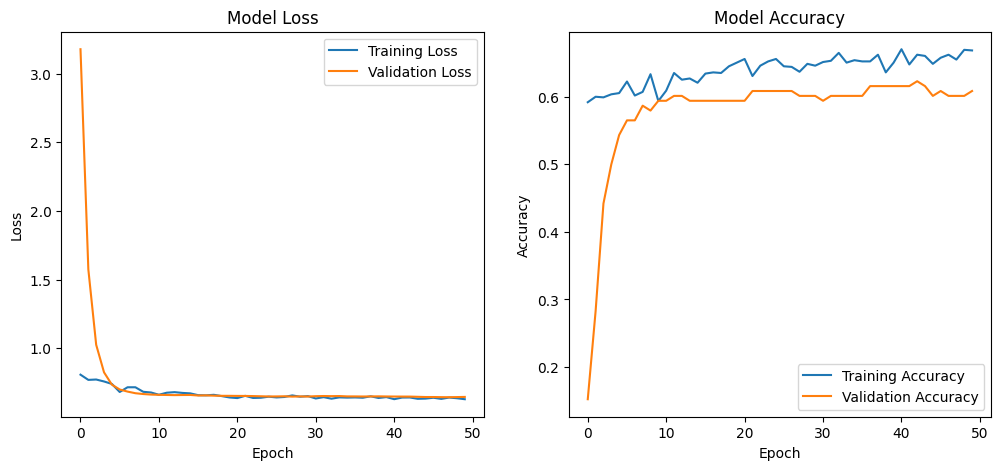

In [15]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[0.65765766 0.34234234]
 [0.5        0.5       ]]


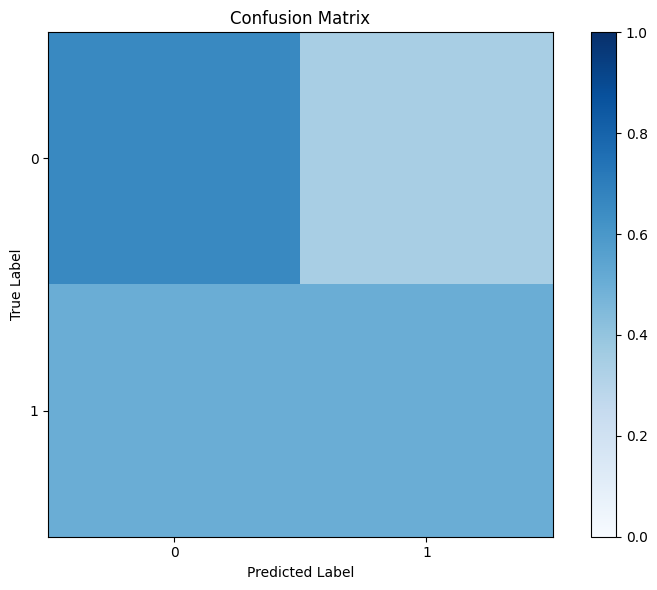

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### More Complex MLP 

In [17]:
def complex_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

In [18]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7217 - loss: 0.8490 - val_accuracy: 0.8623 - val_loss: 0.5306
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 0.7233 - val_accuracy: 0.5145 - val_loss: 0.6453
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.5542 - loss: 0.7207 - val_accuracy: 0.3913 - val_loss: 0.7161
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.4898 - loss: 0.6750 - val_accuracy: 0.3551 - val_loss: 0.7433
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.4931 - loss: 0.6711 - val_accuracy: 0.3551 - val_loss: 0.7445
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.4924 - loss: 0.6622 - val_accuracy: 0.4130 - val_loss: 0.7265
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.4875 - loss: 0.6584 - val_accuracy: 0.4348 - val_loss: 0.7130
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.4738 - loss: 0.6515 - val_accuracy: 0.4638

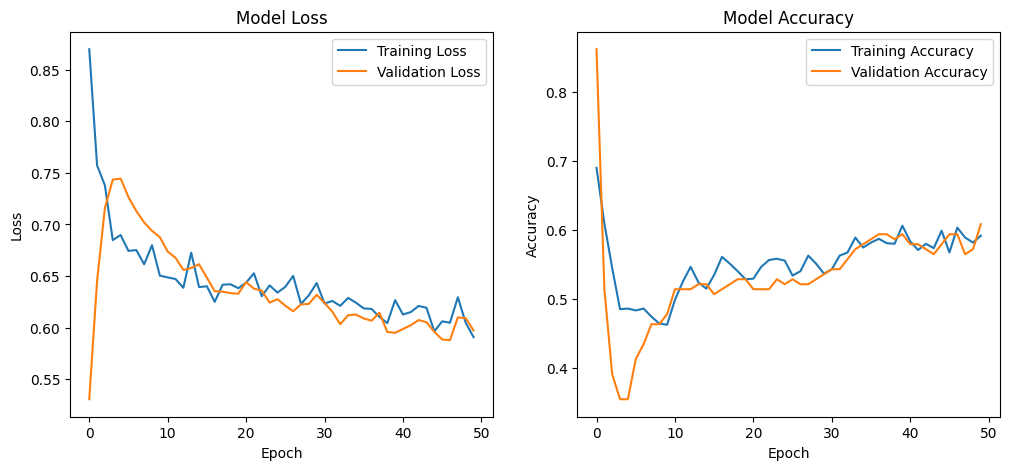

In [19]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
[[0.55855856 0.44144144]
 [0.32142857 0.67857143]]
Precision:  0.6347349177330895


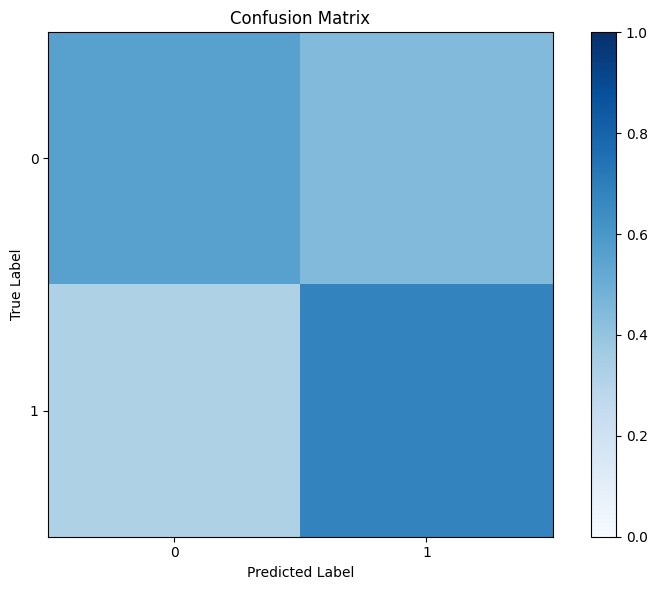

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
print("Precision: ", precision)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

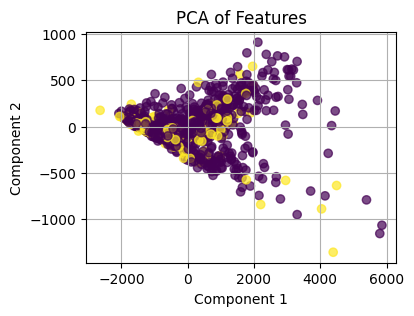

In [21]:
# Plot PCA of features to see if they are separable

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_tracks_features[:,frame,:])
X_pca = pca.transform(train_tracks_features[:,frame,:])

plt.figure(figsize=(4, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_labels.flatten(), cmap='viridis', alpha=0.7)
#sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_labels.flatten())
plt.title('PCA of Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

#### Temporal study

In [77]:
train_tracks_features = train_tracks[:, :, 4:17 ]
test_tracks_features = test_tracks[:, :, 4:17 ]

In [78]:
train_tracks_features.shape

(1108, 1080, 13)

In [79]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data


In [80]:
time_norm_train_track = normalize_cell_time(train_tracks_features)
time_norm_test_track = normalize_cell_time(test_tracks_features)

In [86]:
time_norm_train_track.shape, time_norm_test_track.shape

((1108, 11, 13), (277, 11, 13))

In [87]:
precisions = np.zeros((11, 1))
mean_diagonals = np.zeros((11, 1))

for i in range(11):
    frame = i
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
    class_weights = dict(enumerate(class_weights))

    tf.keras.utils.set_random_seed(config['seed'])

    classifier = complex_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1]) #[:, [3, 8]] 
    classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

    # Train the classifier
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
    classifier.summary()

    x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(time_norm_test_track[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

    history = classifier.fit(time_norm_train_track[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

    y_pred = classifier.predict(x_test_tracks)

    num_classes = len(np.unique(train_labels))
    threshold = 0.5
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_tracks, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    print(conf_matrix_normalized)

    precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
    mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
    print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

    precisions[i] = precision
    mean_diagonals[i] = mean_diagonal


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_70          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4788 - loss: 1.0958 - val_accuracy: 0.8913 - val_loss: 0.9147
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4725 - loss: 0.9594 - val_accuracy: 0.8913 - val_loss: 0.5129
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4847 - loss: 0.9299 - val_accuracy: 0.8913 - val_loss: 0.4235
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5142 - loss: 0.8143 - val_accuracy: 0.8841 - val_loss: 0.4545
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5040 - loss: 0.7511 - val_accuracy: 0.8406 - val_loss: 0.5094
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.5023 - loss: 0.7557 - val_accuracy: 0.7464 - val_loss: 0.5551
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.5288 - loss: 0.7098 - val_accuracy: 0.6667 - val_loss: 0.5826
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.5387 - loss: 0.7060 - val_accuracy: 0.6304 -

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_72          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4613 - loss: 1.1394 - val_accuracy: 0.8913 - val_loss: 0.8880
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.4669 - loss: 0.9961 - val_accuracy: 0.8913 - val_loss: 0.5025
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.4606 - loss: 0.9516 - val_accuracy: 0.8913 - val_loss: 0.4260
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5042 - loss: 0.8477 - val_accuracy: 0.8696 - val_loss: 0.4642
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.5035 - loss: 0.7798 - val_accuracy: 0.8116 - val_loss: 0.5206
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.4919 - loss: 0.7781 - val_accuracy: 0.7174 - val_loss: 0.5651
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5204 - loss: 0.7296 - val_accuracy: 0.6667 - val_loss: 0.5906
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5240 - loss: 0.7236 - val_accuracy: 0.65

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_74          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4576 - loss: 1.0940 - val_accuracy: 0.8913 - val_loss: 0.9054
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4708 - loss: 0.9790 - val_accuracy: 0.8913 - val_loss: 0.5118
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.4964 - loss: 0.9274 - val_accuracy: 0.8913 - val_loss: 0.4317
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.5168 - loss: 0.8316 - val_accuracy: 0.8623 - val_loss: 0.4685
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.5356 - loss: 0.7536 - val_accuracy: 0.7899 - val_loss: 0.5215
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.4980 - loss: 0.7507 - val_accuracy: 0.7319 - val_loss: 0.5621
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.5318 - loss: 0.7152 - val_accuracy: 0.7174 - val_loss: 0.5838
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.5674 - loss: 0.7038 - val_accuracy: 0.6667

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_76          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4769 - loss: 1.0944 - val_accuracy: 0.8913 - val_loss: 0.9027
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.4687 - loss: 0.9681 - val_accuracy: 0.8913 - val_loss: 0.5113
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.4845 - loss: 0.9199 - val_accuracy: 0.8913 - val_loss: 0.4295
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.5243 - loss: 0.8265 - val_accuracy: 0.8623 - val_loss: 0.4637
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.5352 - loss: 0.7362 - val_accuracy: 0.7826 - val_loss: 0.5159
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.5324 - loss: 0.7422 - val_accuracy: 0.6884 - val_loss: 0.5605
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.5482 - loss: 0.7046 - val_accuracy: 0.6739 - val_loss: 0.5861
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.5770 - loss: 0.6843 - val_accuracy: 0.65

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_78          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4748 - loss: 1.0815 - val_accuracy: 0.8913 - val_loss: 0.8956
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.4773 - loss: 0.9771 - val_accuracy: 0.8913 - val_loss: 0.5071
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.4751 - loss: 0.9389 - val_accuracy: 0.8913 - val_loss: 0.4217
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.5206 - loss: 0.8259 - val_accuracy: 0.8768 - val_loss: 0.4515
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5351 - loss: 0.7453 - val_accuracy: 0.8043 - val_loss: 0.5009
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.5251 - loss: 0.7473 - val_accuracy: 0.7246 - val_loss: 0.5432
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.5460 - loss: 0.7204 - val_accuracy: 0.6884 - val_loss: 0.5698
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.5670 - loss: 0.7052 - val_accuracy: 0.6812

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_80          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4710 - loss: 1.0585 - val_accuracy: 0.8913 - val_loss: 0.8743
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.4919 - loss: 0.9389 - val_accuracy: 0.8913 - val_loss: 0.4963
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.4847 - loss: 0.9053 - val_accuracy: 0.8913 - val_loss: 0.4186
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.5055 - loss: 0.8212 - val_accuracy: 0.8696 - val_loss: 0.4492
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.5455 - loss: 0.7359 - val_accuracy: 0.7971 - val_loss: 0.4961
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.5343 - loss: 0.7368 - val_accuracy: 0.7464 - val_loss: 0.5349
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.5561 - loss: 0.7070 - val_accuracy: 0.7536 - val_loss: 0.5584
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.5773 - loss: 0.7051 - val_accuracy: 0.70

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_82          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4735 - loss: 1.0759 - val_accuracy: 0.8913 - val_loss: 0.8870
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.4778 - loss: 0.9464 - val_accuracy: 0.8913 - val_loss: 0.5109
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.5073 - loss: 0.9038 - val_accuracy: 0.8913 - val_loss: 0.4336
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5388 - loss: 0.8047 - val_accuracy: 0.8551 - val_loss: 0.4591
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.5519 - loss: 0.7479 - val_accuracy: 0.7754 - val_loss: 0.5015
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5556 - loss: 0.7306 - val_accuracy: 0.7174 - val_loss: 0.5381
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.5702 - loss: 0.6938 - val_accuracy: 0.7174 - val_loss: 0.5578
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.5798 - loss: 0.6992 - val_accuracy: 0.68

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_84          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4558 - loss: 1.0720 - val_accuracy: 0.8913 - val_loss: 0.8711
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4669 - loss: 0.9302 - val_accuracy: 0.8913 - val_loss: 0.5065
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.4819 - loss: 0.9093 - val_accuracy: 0.8841 - val_loss: 0.4346
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.5299 - loss: 0.8302 - val_accuracy: 0.8623 - val_loss: 0.4658
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.5267 - loss: 0.7444 - val_accuracy: 0.7754 - val_loss: 0.5123
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.5524 - loss: 0.7248 - val_accuracy: 0.7246 - val_loss: 0.5544
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.5520 - loss: 0.7035 - val_accuracy: 0.6884 - val_loss: 0.5813
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.5838 - loss: 0.7068 - val_accuracy: 0.6667

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_86          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4595 - loss: 1.0540 - val_accuracy: 0.8913 - val_loss: 0.8706
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4813 - loss: 0.9210 - val_accuracy: 0.8913 - val_loss: 0.5086
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5041 - loss: 0.9093 - val_accuracy: 0.8913 - val_loss: 0.4361
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5132 - loss: 0.8139 - val_accuracy: 0.8478 - val_loss: 0.4666
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.5491 - loss: 0.7534 - val_accuracy: 0.7971 - val_loss: 0.5134
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.5657 - loss: 0.7219 - val_accuracy: 0.7246 - val_loss: 0.5536
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.5640 - loss: 0.7023 - val_accuracy: 0.7246 - val_loss: 0.5751
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5697 - loss: 0.7166 - val_accuracy: 0.7246

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_88          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4643 - loss: 1.0929 - val_accuracy: 0.8913 - val_loss: 0.8611
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.4788 - loss: 0.9461 - val_accuracy: 0.8913 - val_loss: 0.5045
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.4484 - loss: 0.9366 - val_accuracy: 0.8913 - val_loss: 0.4467
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.4898 - loss: 0.8166 - val_accuracy: 0.8478 - val_loss: 0.4863
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.5070 - loss: 0.7752 - val_accuracy: 0.7681 - val_loss: 0.5366
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5246 - loss: 0.7505 - val_accuracy: 0.7246 - val_loss: 0.5756
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5222 - loss: 0.7158 - val_accuracy: 0.6957 - val_loss: 0.5958
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.5449 - loss: 0.7138 - val_accuracy: 0.68

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_90          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4502 - loss: 1.0603 - val_accuracy: 0.8913 - val_loss: 0.7764
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.4593 - loss: 0.9416 - val_accuracy: 0.8913 - val_loss: 0.4688
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.4644 - loss: 0.9499 - val_accuracy: 0.8841 - val_loss: 0.4325
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.4725 - loss: 0.8322 - val_accuracy: 0.8551 - val_loss: 0.4812
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.4968 - loss: 0.7725 - val_accuracy: 0.7826 - val_loss: 0.5342
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5063 - loss: 0.7579 - val_accuracy: 0.7101 - val_loss: 0.5750
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5451 - loss: 0.7088 - val_accuracy: 0.6812 - val_loss: 0.6001
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.5465 - loss: 0.7159 - val_accuracy: 0.65

In [91]:
conf_matrix_normalized

array([[0.65765766, 0.34234234],
       [0.28571429, 0.71428571]])

In [88]:
precisions

array([[0.60519836],
       [0.66586394],
       [0.68335975],
       [0.63      ],
       [0.66865672],
       [0.65827036],
       [0.65420561],
       [0.66586394],
       [0.67410452],
       [0.63233966],
       [0.69713506]])

In [90]:
mean_diagonals

array([[0.623713  ],
       [0.67728443],
       [0.68613256],
       [0.65057915],
       [0.68178893],
       [0.68194981],
       [0.65926641],
       [0.67728443],
       [0.69079794],
       [0.64140927],
       [0.68597169]])

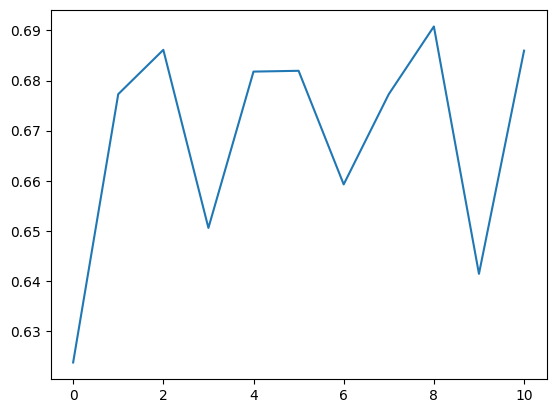

In [92]:
plt.plot(mean_diagonals)

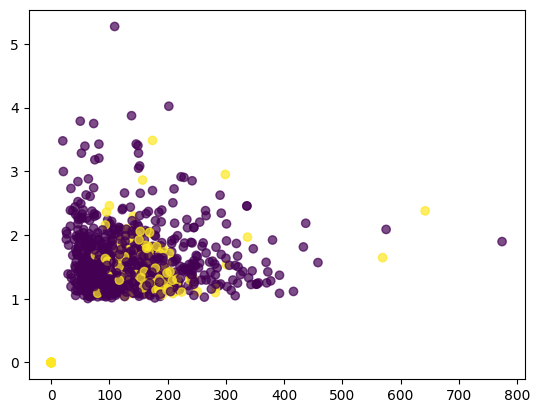

In [63]:
plt.scatter(time_norm_train_track[:,10,2], time_norm_train_track[:,10,3], c=train_labels.flatten(), cmap='viridis', alpha=0.7)

## Image Data

### Full CellFate Workflow 

#### 1. Train Adversarial Autoencoder (AAE)

#### 2. Train AAE with Contrastive loss and Covariance loss

#### 3. Classify with MLP 

#### 4. Evaluation 

#### 5. Temporal study

In [33]:
import numpy as np

def normalize_cell_time_images(images):
    """
    Normalize cell time by extracting images at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - images: numpy array of shape (cells, time, height, width)
      (assumes a cell's lifetime is determined by nonzero pixel values)
    
    Returns:
    - normalized_images: numpy array of shape (cells, 11, height, width)
    """
    num_cells, num_timepoints, height, width = images.shape
    normalized_images = np.zeros((num_cells, 11, height, width))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero frames)
        lifetime = np.count_nonzero(np.sum(images[i], axis=(1, 2)))  # Sum over spatial dims to check for zeros
        #print(lifetime)
        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract images at these indices
        normalized_images[i] = images[i, indices, :, :]

    return normalized_images


In [34]:
train_images_augmented.shape

(2184, 1080, 20, 20)

In [36]:
time_norm_train_images = normalize_cell_time_images(train_images_augmented)
time_norm_test_images = normalize_cell_time_images(test_images)

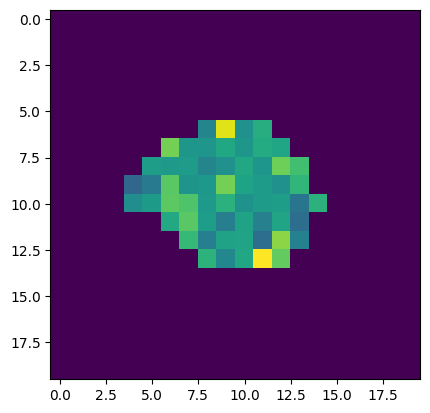

In [43]:
plt.imshow(train_images_augmented[200,10,:,:])

In [ ]:
# np.save("../data/images/time_norm_train_images.npy", time_norm_train_images)
# np.save("../data/images/time_norm_test_images.npy", time_norm_test_images)

#### 6. Latent Space dimensionality study

### Only Adversarial Autoencoder

#### 1. Train Adversarial Autoencoder
With the same number of epochs and hyperparameters as before

#### 2. Evaluation 

### ImageNet classification